In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import cv2
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['resnet50', 'dog-breed-identification']


In [30]:
!ls ../input/dog-breed-identification

labels.csv  sample_submission.csv  test  train


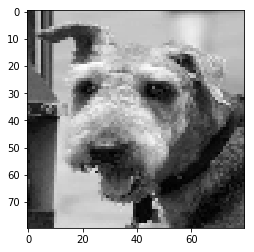

In [31]:
main_dir = "../input/"
train_dir = "dog-breed-identification/train"
path = os.path.join(main_dir,train_dir)

for p in os.listdir(path):
    category = p.split(".")[0]
    img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, dsize=(80, 80))
    plt.imshow(new_img_array,cmap="gray")
    break

In [36]:

from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Activation, Flatten, Dropout, BatchNormalization

import h5py
import keras as k

In [56]:
num_classes = 120
resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(num_classes, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
model.layers[0].trainable = False

In [57]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
activation_443 (Activation)  (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
activation_444 (Activation)  (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 120)               61560     
Total para

In [43]:
import os
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import cv2
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))


dog-breed-identification
resnet50



In [44]:
df_train = pd.read_csv('../input/dog-breed-identification/labels.csv')
df_test = pd.read_csv('../input/dog-breed-identification/sample_submission.csv')

In [45]:
targets_series = pd.Series(df_train['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)

In [46]:
one_hot_labels = np.asarray(one_hot)

In [47]:
im_size = 90

In [48]:
x_train = []
y_train = []
x_test = []

In [49]:
i = 0 
for f, breed in tqdm(df_train.values):
    img = cv2.imread('../input/dog-breed-identification/train/{}.jpg'.format(f))
    label = one_hot_labels[i]
    x_train.append(cv2.resize(img, (im_size, im_size)))
    y_train.append(label)
    i += 1

100%|██████████| 10222/10222 [00:47<00:00, 215.80it/s]


In [50]:
for f in tqdm(df_test['id'].values):
    img = cv2.imread('../input/dog-breed-identification/test/{}.jpg'.format(f))
    x_test.append(cv2.resize(img, (im_size, im_size)))

100%|██████████| 10357/10357 [00:41<00:00, 250.15it/s]


In [51]:
y_train_raw = np.array(y_train, np.uint8)
x_train_raw = np.array(x_train, np.float32) / 255.
x_test  = np.array(x_test, np.float32) / 255.
num_class = y_train_raw.shape[1]

In [52]:
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train_raw, y_train_raw, test_size=0.2, random_state=1)

In [68]:
model.fit(X_train, Y_train, epochs=50, validation_data=(X_valid, Y_valid), verbose=1)


Train on 7155 samples, validate on 3067 samples
Epoch 1/3
7155/7155 [==============================] - 32s 4ms/step - loss: 4.7870 - acc: 0.0067 - val_loss: 4.7852 - val_acc: 0.0137
Epoch 2/3
7155/7155 [==============================] - 8s 1ms/step - loss: 4.7835 - acc: 0.0102 - val_loss: 4.7837 - val_acc: 0.0137
Epoch 3/3
7155/7155 [==============================] - 8s 1ms/step - loss: 4.7810 - acc: 0.0117 - val_loss: 4.7828 - val_acc: 0.0137


In [59]:
preds = model.predict(x_test, verbose=1)


10357/10357 [==============================] - 9s 831us/sample


In [60]:
sub = pd.DataFrame(preds)
# Set column names to those generated by the one-hot encoding earlier
col_names = one_hot.columns.values
sub.columns = col_names
# Insert the column id from the sample_submission at the start of the data frame
sub.insert(0, 'id', df_test['id'])
sub.head(5)

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.000118,0.006826,0.008886,0.095089,0.004257,0.008165,0.000455,0.000848,0.030856,0.007843,0.000389,0.002345,0.000187,0.000489,0.046020,0.009762,0.001590,0.007637,0.000967,0.000407,0.000155,0.023430,0.010080,0.000809,0.000402,0.003491,0.002633,0.004792,0.001370,0.000689,0.004231,0.000471,0.057084,0.000164,0.000311,0.000188,0.000153,0.003222,0.002245,...,0.005269,0.000739,0.000024,0.026182,0.001289,0.000122,0.099181,0.000541,0.036921,0.036965,0.057777,0.042673,0.001777,0.009134,0.000460,0.000347,0.001534,0.002395,0.011800,0.002070,0.002021,0.000903,0.000659,0.004156,0.003078,0.000046,0.001006,0.001594,0.002353,0.002028,0.013392,0.003448,0.004622,0.002154,0.001081,0.000743,0.001860,0.002173,0.002560,0.000536
1,00102ee9d8eb90812350685311fe5890,0.008077,0.008159,0.012465,0.005564,0.007519,0.003480,0.004677,0.007736,0.011395,0.009093,0.005563,0.005451,0.004436,0.005088,0.003864,0.009925,0.004337,0.004944,0.003158,0.011502,0.003917,0.008045,0.005169,0.007691,0.016363,0.003664,0.004298,0.005889,0.016241,0.011731,0.006736,0.015304,0.008125,0.002836,0.005875,0.008332,0.006068,0.006161,0.007255,...,0.006431,0.003717,0.006853,0.017505,0.014580,0.005588,0.006959,0.014608,0.014543,0.013461,0.005251,0.005456,0.006068,0.012496,0.015072,0.006070,0.006268,0.004492,0.025257,0.006667,0.008454,0.006107,0.006838,0.004194,0.012446,0.006433,0.005637,0.009478,0.005469,0.006778,0.016148,0.013888,0.006129,0.005783,0.011562,0.007218,0.011439,0.004139,0.013577,0.008327
2,0012a730dfa437f5f3613fb75efcd4ce,0.000011,0.005401,0.003747,0.178139,0.001482,0.004819,0.000237,0.000763,0.068620,0.001972,0.000220,0.000778,0.000039,0.000216,0.068891,0.004063,0.000714,0.009872,0.000518,0.000067,0.000067,0.042689,0.007238,0.000334,0.000035,0.000872,0.000928,0.002217,0.000690,0.000147,0.001798,0.000210,0.063604,0.000066,0.000122,0.000075,0.000086,0.001806,0.002755,...,0.006268,0.000610,0.000004,0.023288,0.000380,0.000019,0.104833,0.000162,0.023187,0.073625,0.059168,0.057101,0.000327,0.010006,0.000075,0.000121,0.000852,0.001903,0.002650,0.001734,0.000951,0.000515,0.000324,0.002767,0.001153,0.000003,0.000778,0.001198,0.001166,0.001575,0.004780,0.000775,0.002475,0.001402,0.000255,0.000258,0.001622,0.001085,0.002912,0.000689
3,001510bc8570bbeee98c8d80c8a95ec1,0.006635,0.007721,0.009488,0.012736,0.008514,0.004919,0.004023,0.004755,0.013213,0.009740,0.006149,0.006642,0.002467,0.006715,0.009127,0.009726,0.005544,0.005108,0.004155,0.008445,0.004060,0.008058,0.006881,0.009725,0.010251,0.005755,0.006487,0.005763,0.012650,0.008567,0.009478,0.007612,0.013060,0.003913,0.005391,0.009185,0.012005,0.008022,0.007651,...,0.007629,0.005208,0.003408,0.020247,0.007195,0.005721,0.009664,0.009061,0.023770,0.012965,0.010415,0.007398,0.006938,0.018320,0.008563,0.007625,0.006314,0.006496,0.017800,0.006675,0.009803,0.004414,0.006129,0.007792,0.013208,0.004046,0.007095,0.007837

In [61]:
sub.to_csv('submission.csv', index = False)